In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import XLMRobertaModel, XLMRobertaTokenizer

In [ ]:
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import XLMRobertaModel, XLMRobertaTokenizer

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

class Encoder:
    def __init__(self, model_name_or_path="FacebookAI/xlm-roberta-base", device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        self.model = XLMRobertaModel.from_pretrained(
            model_name_or_path, use_cache=False
        ).to(self.device)
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(
            "FacebookAI/xlm-roberta-base", use_cache=False
        )

    def encode(self, text: str, max_len = 512):
        input_text = text
        encoded_text = self.tokenizer.encode_plus(
            input_text,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        ).to(self.device)
        with torch.no_grad():
            outputs = self.model(encoded_text['input_ids'], attention_mask=encoded_text['attention_mask'])
        embeddings = average_pool(
            outputs.last_hidden_state, encoded_text["attention_mask"]
        )
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings.cpu()



In [ ]:
encoder = Encoder(device="cpu")
text = "abcd"
embedding = encoder.encode(text=text, max_len=len(text))
embedding = embedding.squeeze().tolist()
embedding

torch.Size([1, 4, 768])


[0.001421170076355338,
 0.0059421854093670845,
 0.0023128546308726072,
 -0.0005641273455694318,
 0.0017966281156986952,
 -0.0004045845998916775,
 -0.0023539250250905752,
 0.0007239971891976893,
 0.0032716377172619104,
 -0.0020857672207057476,
 -0.0020805795211344957,
 0.0017569285118952394,
 0.0015699431532993913,
 -0.0013789342483505607,
 -0.0015392889035865664,
 0.0020660385489463806,
 -0.0010161767713725567,
 -0.0006509065278805792,
 0.004189345054328442,
 0.0032878019846975803,
 0.0068085468374192715,
 0.0011198101565241814,
 0.0025825328193604946,
 0.005479884799569845,
 0.0003530103131197393,
 -0.00016028550453484058,
 0.0010178671218454838,
 0.0015538078732788563,
 0.0031229988671839237,
 0.001442440552636981,
 0.004216521047055721,
 -0.0007297881529666483,
 0.0036545831244438887,
 0.005411991849541664,
 0.0033772753085941076,
 0.0026068291626870632,
 -0.0013410105602815747,
 -0.002591788535937667,
 0.006752946879714727,
 0.004664186853915453,
 0.0032147555612027645,
 0.00430604

# Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/19_35000.xlsx").drop(['Unnamed: 0', 'Title'], axis = 1)
df = df.drop_duplicates()

t = df.groupby('SMILES', as_index = False).count().sort_values(by = 'IC50', ascending = False)
ic50, smiles = [], []
for i in t[t['IC50'] > 1]['SMILES']:
    if round(df[df['SMILES'] == i]['IC50'].std(), 3) < 20:
        smiles += [i]
        ic50 += [df[df['SMILES'] == i]['IC50'].median()]

df = df.merge(t[t['IC50'] == 1]['SMILES'], on = 'SMILES')
df = pd.concat((df, pd.DataFrame({'IC50': ic50, 'SMILES': smiles})))
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
50,2.450000,C[C@@]1(O)CC(C)(C)O[C@@H]([C@H]12)C[C@H](C)CC2
51,1.706500,CCSc(n1)[nH]c(c12)cccc2
52,14.150000,C[N+](C)(C)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2
53,0.263500,n1cccc(c1c23)ccc2cccn3


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/19_35000.xlsx").drop(['Unnamed: 0', 'Title'], axis = 1)
df

,IC50,SMILES
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...
36372,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [ ]:
df.iloc[120]

IC50                                           0.000597
SMILES    O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C(F)(F)F)cccc2
Name: 120, dtype: object

In [ ]:
import numpy as np
import pandas as pd

cnt = 0
all_cnt = len(df)
encoder = Encoder(device="cuda")

max_length = df["SMILES"].str.len().max()

for i in range(768):
    df[f'emb_{i+1}'] = np.nan

def process_smiles(smiles, index):
    global cnt
    cnt += 1
    embedding = encoder.encode(text=smiles, max_len=max_length)
    embedding = embedding.squeeze().tolist()
    for i, emb in enumerate(embedding):
        df.loc[index, f'emb_{i+1}'] = emb
    print(f"[{cnt}/{all_cnt}] {smiles}")
    return pd.Series(embedding)

for index, smiles in enumerate(df['SMILES']):
    process_smiles(smiles, index)


Выходные данные были обрезаны до нескольких последних строк (5000).
[31233/36232] s1cccc1C(=O)Nc(cc2)cc(c2C)NC(=O)c3c(OC)c(OC)ccc3
[31234/36232] CN(C)C(=O)CSc(o1)nnc1-c2cc(-c3cccs3)nc(c24)cccc4
[31235/36232] o1cccc1CNC(=O)c2ccc(cc2)S(=O)(=O)N(CCC3)c(c34)cccc4
[31236/36232] Cn1ccnc1C#Cc2c(C)onc2-c3cc(OC)c(OC)c(c3)OC
[31237/36232] Cc1c(C)ccc(c1)OCC(=O)OCCN(C2=O)C(=O)c(c23)cccc3
[31238/36232] C[C@H]1CCC[C@H](C)N1C(=O)CSc(s2)nnc2NC(=O)c3cccs3
[31239/36232] C1CCc(c12)ccc(c2)NC(=O)CSc(n3CC=C)nnc3-c4cccs4
[31240/36232] c1cccc(c1C)-n2c(SC(C)C)nnc2Cn3c(=O)sc(c34)cccc4
[31241/36232] c1cccc(c12)sc(n2)C(\CCC(=O)O)=C\c(c3)ccc(c34)OCO4
[31242/36232] c1ccc(F)cc1C(=O)N(CC2)c(c23)ccc(c3)-c4csc(n4)NC
[31243/36232] c1ccccc1C(=O)[C@@H](C)OC(=O)CCCC(=O)Nc(cc2)ccc2C
[31244/36232] CCCOP(=O)(OCCC)C1(CCCCC1)Nc(cc2)ccc2C
[31245/36232] c1csc(c12)cc(n2C)C(=O)N3CCN(CC3)c(c4C)cc(C)cc4
[31246/36232] C1COCCN1C(=O)C[C@@]23C[C@]4(c(cc5)ccc5C)C[C@H](C3)C[C@H](C2)C4
[31247/36232] c1ccccc1-c(n2)cc(n(c23)ncn3)N4CCN(CC4)S(=

In [ ]:
df.iloc[36231]

IC50                                                  2.5065
SMILES     c1ccnc(c12)c(O)c(cc2C)/C=C/c(cc3)[n+](C)c(c34)...
emb_1                                               0.003227
emb_2                                               0.003116
emb_3                                               -0.00243
                                 ...                        
emb_764                                            -0.001563
emb_765                                             0.010825
emb_766                                            -0.005179
emb_767                                             0.002197
emb_768                                             0.010157
Name: 54, Length: 770, dtype: object

In [ ]:
df_emb = df.iloc[:36231]
df_emb

,IC50,SMILES,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000101,0.001807,-0.000645,-0.000006,-0.000138,-0.001144,-0.001293,-0.002953,...,-0.001834,0.017180,0.001505,-0.002770,0.000326,-0.003036,0.008919,-0.002545,0.001890,0.007602
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,-0.000155,0.001521,-0.000990,-0.000329,0.000643,0.000183,-0.001402,-0.001954,...,-0.002121,0.016974,0.001569,-0.002658,0.000256,-0.004081,0.009028,-0.001336,0.002078,0.010244
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000784,0.001236,-0.001476,0.000384,0.000555,0.000504,-0.000652,-0.000691,...,-0.001142,0.018263,0.001590,-0.002175,0.000271,-0.004049,0.009972,-0.001952,0.001872,0.010107
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000490,0.001883,-0.001169,0.000126,0.000094,0.000801,-0.000700,-0.000421,...,-0.001103,0.017261,0.001449,-0.001908,-0.000097,-0.004492,0.010383,-0.002227,0.001328,0.009408
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.003591,0.002562,-0.002055,-0.000864,-0.002107,0.002414,-0.001582,-0.004409,...,-0.001171,0.019306,0.001776,-0.004563,-0.000262,-0.003049,0.007252,0.000325,0.001926,0.005020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,0.084500,CC(C)[C@@H](C(=O)O)NC(=O)C1=C[C@H]([C@@H]([C@H...,0.001350,0.002665,-0.001681,0.000551,0.001128,0.003433,-0.001637,-0.003364,...,-0.001608,0.019519,0.001852,-0.003870,0.000427,-0.003802,0.008105,-0.004032,0.002644,0.009223
50,2.450000,C[C@@]1(O)CC(C)(C)O[C@@H]([C@H]12)C[C@H](C)CC2,0.002285,0.002103,-0.001789,-0.001240,0.000691,0.006776,-0.001597,-0.003865,...,-0.002242,0.019251,0.001991,-0.003549,-0.000171,-0.002424,0.004933,-0.005333,0.002320,0.007084
51,1.706500,CCSc(n1)[nH]c(c12)cccc2,0.000354,0.002609,-0.000338,-0.001217,-0.000134,-0.001668,-0.000673,-0.001844,...,-0.001182,0.016410,0.001221,-0.003494,-0.000470,-0.004617,0.008153,-0.001531,0.000861,0.005991
52,14.150000,C[N+](C)(C)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,0.002915,0.003490,-0.002538,-0.001531,-0.001421,0.006860,-0.001790,-0.002302,...,-0.000743,0.017875,0.002312,-0.004928,0.000063,-0.002143,0.010307,-0.003485,0.001583,0.011020


In [ ]:
df_emb.isna().sum().sum()

0

In [ ]:
df_emb.to_csv("/content/drive/MyDrive/chem_roberta_emb_gpu-right.csv")

In [ ]:
df_em = pd.read_csv("/content/drive/MyDrive/chem_roberta_emb_gpu-right.csv")
len(df_em)

36231

In [ ]:
df_em.drop(['Unnamed: 0'], axis = 1, inplace=True)
df_em.head()

,IC50,SMILES,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000101,0.001807,-0.000645,-0.000006,-0.000138,-0.001144,-0.001293,-0.002953,...,-0.001834,0.017180,0.001505,-0.002770,0.000326,-0.003036,0.008919,-0.002545,0.001890,0.007602
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,-0.000155,0.001521,-0.000990,-0.000329,0.000643,0.000183,-0.001402,-0.001954,...,-0.002121,0.016974,0.001569,-0.002658,0.000256,-0.004081,0.009028,-0.001336,0.002078,0.010244
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000784,0.001236,-0.001476,0.000384,0.000555,0.000504,-0.000652,-0.000691,...,-0.001142,0.018263,0.001590,-0.002175,0.000271,-0.004049,0.009972,-0.001952,0.001872,0.010107
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000490,0.001883,-0.001169,0.000126,0.000094,0.000801,-0.000700,-0.000421,...,-0.001103,0.017261,0.001449,-0.001908,-0.000097,-0.004492,0.010383,-0.002227,0.001328,0.009408
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.003591,0.002562,-0.002055,-0.000864,-0.002107,0.002414,-0.001582,-0.004409,...,-0.001171,0.019306,0.001776,-0.004563,-0.000262,-0.003049,0.007252,0.000325,0.001926,0.005020


In [ ]:
data_dsc = df_em.copy()

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.8 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score as f1, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_dsc['IC50_log'] = np.log1p(data_dsc['IC50'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_dsc.drop(['IC50', 'SMILES', 'IC50_log'], axis = 1), data_dsc['IC50'], test_size = 0.2, random_state = 42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 17)

In [ ]:
model = CatBoostRegressor(iterations = 4000,
                          verbose = 500,
                          l2_leaf_reg = 1e1,
                          loss_function = 'RMSE',
                          eval_metric = 'MAE',
                          task_type="GPU",
                          devices='0')

model.fit(X_train, y_train, eval_set = (X_val, y_val))
preds_class = model.predict(X_test)
print(f'MSE: {mse(y_test, preds_class)}')
print(f'MAE: {mae(y_test, preds_class)}')
print(f'RMSE: {mse(y_test, preds_class, squared = False)}')
print(f'R2: {r2_score(y_test, preds_class)}')

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 7.2931747	test: 7.6448806	best: 7.6448806 (0)	total: 196ms	remaining: 13m 4s
500:	learn: 5.6700599	test: 7.3516940	best: 7.3287487 (140)	total: 35.2s	remaining: 4m 6s
1000:	learn: 5.2654325	test: 7.3757073	best: 7.3287487 (140)	total: 1m 5s	remaining: 3m 17s
1500:	learn: 5.0650515	test: 7.4153418	best: 7.3287487 (140)	total: 1m 37s	remaining: 2m 41s
2000:	learn: 4.9596307	test: 7.4415615	best: 7.3287487 (140)	total: 2m 7s	remaining: 2m 7s
2500:	learn: 4.8978839	test: 7.4527476	best: 7.3287487 (140)	total: 2m 33s	remaining: 1m 32s
3000:	learn: 4.8605820	test: 7.4657219	best: 7.3287487 (140)	total: 2m 59s	remaining: 59.8s
3500:	learn: 4.8196182	test: 7.4819038	best: 7.3287487 (140)	total: 3m 21s	remaining: 28.8s
3999:	learn: 4.7849056	test: 7.4939805	best: 7.3287487 (140)	total: 3m 44s	remaining: 0us
bestTest = 7.328748728
bestIteration = 140
Shrink model to first 141 iterations.
MSE: 4655.860077956101
MAE: 7.755334294290141
RMSE: 68.23386313229013
R2: 0.008673436823430247


# regnet

# Model

In [ ]:
import torch

In [ ]:
batch_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = df_em.copy()
df

,IC50,SMILES,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,emb_768
0,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000101,0.001807,-0.000645,-0.000006,-0.000138,-0.001144,-0.001293,-0.002953,...,-0.001834,0.017180,0.001505,-0.002770,0.000326,-0.003036,0.008919,-0.002545,0.001890,0.007602
1,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,-0.000155,0.001521,-0.000990,-0.000329,0.000643,0.000183,-0.001402,-0.001954,...,-0.002121,0.016974,0.001569,-0.002658,0.000256,-0.004081,0.009028,-0.001336,0.002078,0.010244
2,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000784,0.001236,-0.001476,0.000384,0.000555,0.000504,-0.000652,-0.000691,...,-0.001142,0.018263,0.001590,-0.002175,0.000271,-0.004049,0.009972,-0.001952,0.001872,0.010107
3,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000490,0.001883,-0.001169,0.000126,0.000094,0.000801,-0.000700,-0.000421,...,-0.001103,0.017261,0.001449,-0.001908,-0.000097,-0.004492,0.010383,-0.002227,0.001328,0.009408
4,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.003591,0.002562,-0.002055,-0.000864,-0.002107,0.002414,-0.001582,-0.004409,...,-0.001171,0.019306,0.001776,-0.004563,-0.000262,-0.003049,0.007252,0.000325,0.001926,0.005020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36226,0.084500,CC(C)[C@@H](C(=O)O)NC(=O)C1=C[C@H]([C@@H]([C@H...,0.001350,0.002665,-0.001681,0.000551,0.001128,0.003433,-0.001637,-0.003364,...,-0.001608,0.019519,0.001852,-0.003870,0.000427,-0.003802,0.008105,-0.004032,0.002644,0.009223
36227,2.450000,C[C@@]1(O)CC(C)(C)O[C@@H]([C@H]12)C[C@H](C)CC2,0.002285,0.002103,-0.001789,-0.001240,0.000691,0.006776,-0.001597,-0.003865,...,-0.002242,0.019251,0.001991,-0.003549,-0.000171,-0.002424,0.004933,-0.005333,0.002320,0.007084
36228,1.706500,CCSc(n1)[nH]c(c12)cccc2,0.000354,0.002609,-0.000338,-0.001217,-0.000134,-0.001668,-0.000673,-0.001844,...,-0.001182,0.016410,0.001221,-0.003494,-0.000470,-0.004617,0.008153,-0.001531,0.000861,0.005991
36229,14.150000,C[N+](C)(C)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,0.002915,0.003490,-0.002538,-0.001531,-0.001421,0.006860,-0.001790,-0.002302,...,-0.000743,0.017875,0.002312,-0.004928,0.000063,-0.002143,0.010307,-0.003485,0.001583,0.011020


In [ ]:
# X = df.groupby('SMILES').median().reset_index()
# X = X.drop('IC50', axis=1)

In [ ]:
y = df['IC50']
X = X.drop(['IC50', 'SMILES'], axis=1)

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=True
)
train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
X.shape

(36231, 768)

In [ ]:
import torch
import torch.nn as nn

class RegNet(nn.Module):
    def __init__(self, input_neurons=768, n_hidden_neurons=256*2):
        super(RegNet, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_neurons, n_hidden_neurons),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Sigmoid(),
            nn.Linear(n_hidden_neurons, 1)
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x


In [ ]:
from sklearn.metrics import r2_score, f1_score

def train_model(net, train_dataloader, val_dataloader, loss, optimizer, scheduler, num_epochs,
                val_accuracy_history, train_accuracy_history, val_loss_history, train_loss_history):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                net.train()
            else:
                dataloader = val_dataloader
                net.eval()

            running_loss = 0.
            running_acc = 0.

            for i, (X, y) in enumerate(dataloader):
                X = X.to(device)
                y = y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    preds = net.forward(X).squeeze(-1)
                    loss_value = loss(preds, y)
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()


                # Calculate R^2
                if phase == 'train':
                    train_r2 = r2_score(y.cpu().detach().numpy(), preds.cpu().detach().numpy())
                    train_accuracy_history.append(train_r2)
                else:
                    val_r2 = r2_score(y.cpu().detach().numpy(), preds.cpu().detach().numpy())
                    val_accuracy_history.append(val_r2)

            if phase == 'train':
              train_loss_history.append(running_loss / len(dataloader))
            else:
              val_loss_history.append(running_loss / len(dataloader))

            epoch_loss = running_loss / len(dataloader)

            print('{} Loss: {:.4f} R^2: {:.4f}'.format(phase, epoch_loss, val_r2 if phase == 'val' else train_r2), flush=True)

    return net


In [ ]:
reg_net = RegNet()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(reg_net.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
epoch_number = 200

In [ ]:
val_accuracy_history = []
val_loss_history = []
train_accuracy_history = []
train_loss_history = []

train_model(
    net=reg_net,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss=loss,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=epoch_number,
    val_accuracy_history=val_accuracy_history,
    val_loss_history=val_loss_history,
    train_accuracy_history=train_accuracy_history,
    train_loss_history=train_loss_history
);

Epoch 0/199:


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 2559.7107 R^2: -1.1205
val Loss: 1590.6071 R^2: 0.0552
Epoch 1/199:
train Loss: 2532.4931 R^2: -13.1856
val Loss: 1561.5524 R^2: 0.1613
Epoch 2/199:
train Loss: 2889.9626 R^2: -0.0289
val Loss: 1527.0758 R^2: 0.2716
Epoch 3/199:
train Loss: 2429.4716 R^2: 0.3396
val Loss: 1485.1615 R^2: 0.4505
Epoch 4/199:
train Loss: 2380.1947 R^2: -5.5019
val Loss: 1478.0561 R^2: 0.4603
Epoch 5/199:
train Loss: 2372.2280 R^2: -3.3431
val Loss: 1479.1224 R^2: 0.3764
Epoch 6/199:
train Loss: 2370.3357 R^2: 0.2240
val Loss: 1472.1362 R^2: 0.4105
Epoch 7/199:
train Loss: 2357.5559 R^2: 0.5023
val Loss: 1463.4058 R^2: 0.4858
Epoch 8/199:
train Loss: 2349.8307 R^2: -10.9485
val Loss: 1458.8603 R^2: 0.4943
Epoch 9/199:
train Loss: 2344.6672 R^2: -23.9998
val Loss: 1458.3868 R^2: 0.4960
Epoch 10/199:
train Loss: 2349.1617 R^2: 0.1065
val Loss: 1457.8843 R^2: 0.4992
Epoch 11/199:
train Loss: 2343.0655 R^2: -0.4788
val Loss: 1457.4139 R^2: 0.5026
Epoch 12/199:
train Loss: 2342.5213 R^2: -5.7377
val

KeyboardInterrupt: 

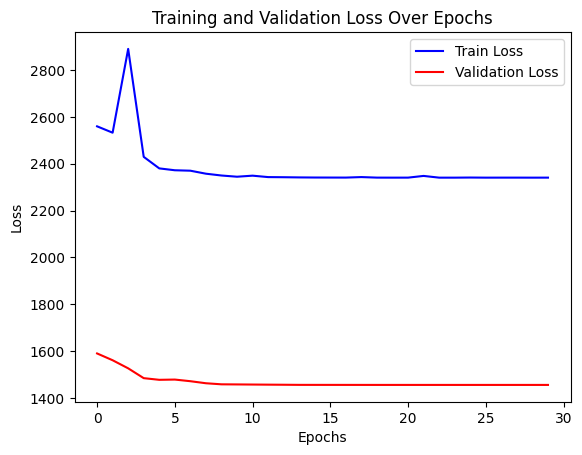

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Train Loss', color='blue')

plt.plot(val_loss_history, label='Validation Loss', color='red')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

plt.show()

In [ ]:
reg_net.eval()

for i, (X, y) in enumerate(val_dataloader):
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        preds = reg_net.forward(X).squeeze(-1)
        loss_value = loss(preds, y)

        val_r2 = r2_score(y.cpu().detach().numpy(), preds.cpu().detach().numpy())
        print('preds', preds.cpu().detach().numpy(), 'y', y.cpu().detach().numpy(), '\nr2', val_r2)


preds [ 2.4114425  2.3035085  4.3312325  4.487876  16.79857    4.396003
 57.83521    3.7355335  6.3219995  4.228928   3.292011   4.257452
  4.289681   3.944678   2.4997225  2.2782702  3.760724   3.9553602
  2.1246946  2.8185713  5.2952867  2.6360223  4.5852947 29.794
  1.2309961  5.552841  38.91216    6.9347973  5.5404587  6.275298
  6.2155924 12.132869   6.596962   4.4593396 36.94041    4.663378
  2.3929095  4.213682  20.290787   6.0765176  2.3796866  3.3912141
 24.86981   19.008198   2.7437906  4.9626074  6.2863617  2.744076
  6.7997646  4.635171   4.928528   3.507263   6.681798   5.2795277
  2.2880456  6.127224   3.4504445 29.43338    6.666174   4.8815165
  3.9613953  1.3842452  4.5211763  3.5474923] y [3.3630e+00 1.9120e+00 2.4130e+00 1.9400e+00 3.4440e+00 4.4050e+00
 3.0000e+02 4.1490e+00 3.0000e+00 7.0000e-02 4.5950e+00 3.8650e+00
 1.9740e+00 2.5720e+00 8.6800e-01 1.4310e+00 7.3510e+00 1.1400e-01
 4.0340e+00 4.8200e-01 6.0340e+00 8.4080e+00 2.4990e+00 1.1103e+01
 6.0000e-01 4.310